In [1]:
import os
import random
import shutil
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import Model
from tensorflow.keras.utils import img_to_array, load_img
from shutil import copyfile
from PIL import Image
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
print(tf.__version__)

2.12.0


In [3]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95 and logs.get('val_accuracy')>=0.94):
      self.model.stop_training = True

callbacks = myCallback()

In [4]:
# Resized gambar agar memiliku jumlah pixel yang sama
def copy_to_working(path, new_path):
  for filename in os.scandir(path):
#     img = Image.open(os.path.join(path, filename.name))
#     img_resized= img.resize(new_size)
#     img_resized.save(os.path.join(new_path, filename.name))
    copyfile(os.path.join(path, filename.name), os.path.join(new_path, filename.name))

In [5]:
# Membuat direktori untuk menempatka data yang akan digunakan

resized_dir = '/kaggle/working/Resized_Dataset'
source_dir = '/kaggle/input/leaf-or-not/Leaf or Not'

if os.path.exists(resized_dir):
  shutil.rmtree(resized_dir)

def create_train_test_dirs(resized_path):
  os.mkdir(resized_path)
  os.mkdir(os.path.join(resized_path, 'train'))
  os.mkdir(os.path.join(resized_path, 'val'))
  os.mkdir(os.path.join(resized_path, 'test'))

  for foldername in os.listdir(os.path.join(source_dir, '')):
    for i in os.listdir(resized_path):
      os.mkdir(os.path.join(resized_path, i, foldername))

try:
  create_train_test_dirs(resized_path=resized_dir)
except FileExistsError:
  print("File Sudah Ada")

In [6]:
# Membuat fungsi untuk menyalin data dari sumber data ke train dan test dir seusai yang diinginkan
def split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TESTING_DIR, SPLIT_SIZE):
  all_files = []

  for file_name in os.listdir(SOURCE_DIR):
      file_path = SOURCE_DIR + file_name

      if os.path.getsize(file_path):
          all_files.append(file_name)
      else:
          print('{} is zero length, so ignoring'.format(file_name))

  train_val_size = int(SPLIT_SIZE * len(all_files))
  val_test_size = int(len(all_files) - int((len(all_files)-train_val_size)/2))
  shuffled = random.sample(all_files, len(all_files))
  train, val, test = shuffled[:train_val_size], shuffled[train_val_size:val_test_size], shuffled[val_test_size:]

  for filename in train:
    copyfile(SOURCE_DIR + filename, TRAINING_DIR + filename)

  for filename in val:
    copyfile(SOURCE_DIR + filename, VALIDATION_DIR + filename)

  for filename in test:
    copyfile(SOURCE_DIR + filename, TESTING_DIR + filename)

In [7]:
def resize_dataset(path, new_size):
  for filename in os.scandir(path):
    img = Image.open(os.path.join(path, filename.name)).convert('RGB')
    img_resized= img.resize(new_size)
    img_resized.save(os.path.join(path, filename.name))

In [8]:
#  def remove_bg(path):
#     for filename in os.scandir(path):
#         img = Image.open(os.path.join(path, filename.name))

#         # Mengubah gambar menjadi mode RGBA
#         img = img.convert("RGBA")

#         # Ambang nilai piksel untuk background (misal: 200, 200, 200)
#         threshold = (200, 200, 200)

#         # Membuat mask untuk mengidentifikasi background
#         mask = Image.new('L', img.size, 255)
#         for x in range(img.width):
#             for y in range(img.height):
#                 r, g, b, a = img.getpixel((x, y))
#                 if (r, g, b) <= threshold:
#                     mask.putpixel((x, y), 0)

#         # Mengganti background menjadi transparan
#         img.putalpha(mask)
#         img = img.convert("RGB")

#         # Menyimpan gambar hasil penghapusan background
#         img.save(os.path.join(path, filename.name))

In [9]:
# Source
leaf_source = os.path.join(source_dir, 'Leaf/')
not_source = os.path.join(source_dir, 'Not/')

# Test Source
test_leaf_source = os.path.join(resized_dir, 'test/Leaf/')
test_not_source = os.path.join(resized_dir, 'test/Not/')

# Train Source
train_leaf_source = os.path.join(resized_dir, 'train/Leaf/')
train_not_source = os.path.join(resized_dir, 'train/Not/')

# Val Source
val_leaf_source = os.path.join(resized_dir, 'val/Leaf/')
val_not_source = os.path.join(resized_dir, 'val/Not/')

In [10]:
# Pisahkan dan salin data mengguakan fungsi split_data
split_size = .6

split_data(leaf_source, train_leaf_source, val_leaf_source, test_leaf_source, split_size)
split_data(not_source, train_not_source, val_not_source, test_not_source, split_size)

# new_size = (224, 224)
# resize_dataset(train_leaf_source, new_size)
# resize_dataset(train_not_source, new_size)
# resize_dataset(val_leaf_source, new_size)
# resize_dataset(val_not_source, new_size)
# resize_dataset(test_leaf_source, new_size)
# resize_dataset(test_not_source, new_size)

# remove_bg(train_leaf_source)
# remove_bg(val_leaf_source)
# remove_bg(test_leaf_source)

In [11]:
# # Melihat contoh ukuran dataset
# sample_image  = load_img('/kaggle/input/coffee-leaf-diseases/train/phoma/16.jpg')
# sample_array = img_to_array(sample_image)
# print(f"Each image has shape: {sample_array.shape}")

# sample_image  = load_img('/kaggle/input/coffee-leaf-diseases/test/phoma/500.jpg')
# sample_array = img_to_array(sample_image)
# print(f"Each image has shape: {sample_array.shape}")

In [12]:
# train_source_list = [train_miner_source, train_healthy_source, train_phoma_source, train_rust_source]
# test_source_list = [test_miner_source, test_healthy_source, test_phoma_source, test_rust_source]
# train_resized_list = [train_miner_resized, train_healthy_resized, train_phoma_resized, train_rust_resized]
# test_resized_list = [test_miner_resized, test_healthy_resized, test_phoma_resized, test_rust_resized]

# for train in train_source_list:
#     for resized in train_resized_list:
#         if train_source_list.index(train) == train_resized_list.index(resized):
#           copy_to_working(train, resized)
        
# for test in test_source_list:
#     for resized in test_resized_list:
#         if test_source_list.index(test) == test_resized_list.index(resized):
#           copy_to_working(test, resized)

In [13]:
# Jumlah gambar yang ingin tersisa di setiap folder
train_jumlah_tersisa = 2000
val_jumlah_tersisa = 500
test_jumlah_tersisa = 500

for folder in ['/kaggle/working/Resized_Dataset/train/Not', '/kaggle/working/Resized_Dataset/train/Leaf']:
    # Dapatkan daftar semua file gambar dalam folder
    gambar = [file for file in os.listdir(folder) if file.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

    # Pastikan jumlah gambar yang ingin tersisa tidak melebihi jumlah gambar yang ada
    jumlah_tersisa = min(train_jumlah_tersisa, len(gambar))

    # Jumlah gambar yang akan dihapus
    jumlah_hapus = len(gambar) - train_jumlah_tersisa

    # Acak urutan gambar
    random.shuffle(gambar)

    # Hapus gambar secara acak sampai tersisa jumlah tertentu
    for i in range(jumlah_hapus):
        file = os.path.join(folder, gambar[i])
        os.remove(file)
    
for folder in ['/kaggle/working/Resized_Dataset/val/Not', '/kaggle/working/Resized_Dataset/val/Leaf']:
    # Dapatkan daftar semua file gambar dalam folder
    gambar = [file for file in os.listdir(folder) if file.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

    # Pastikan jumlah gambar yang ingin tersisa tidak melebihi jumlah gambar yang ada
    jumlah_tersisa = min(val_jumlah_tersisa, len(gambar))

    # Jumlah gambar yang akan dihapus
    jumlah_hapus = len(gambar) - val_jumlah_tersisa

    # Acak urutan gambar
    random.shuffle(gambar)

    # Hapus gambar secara acak sampai tersisa jumlah tertentu
    for i in range(jumlah_hapus):
        file = os.path.join(folder, gambar[i])
        os.remove(file)
        
for folder in ['/kaggle/working/Resized_Dataset/test/Not', '/kaggle/working/Resized_Dataset/test/Leaf']:
    # Dapatkan daftar semua file gambar dalam folder
    gambar = [file for file in os.listdir(folder) if file.endswith(('.jpg', '.jpeg', '.png', '.gif'))]

    # Pastikan jumlah gambar yang ingin tersisa tidak melebihi jumlah gambar yang ada
    jumlah_tersisa = min(test_jumlah_tersisa, len(gambar))

    # Jumlah gambar yang akan dihapus
    jumlah_hapus = len(gambar) - test_jumlah_tersisa

    # Acak urutan gambar
    random.shuffle(gambar)

    # Hapus gambar secara acak sampai tersisa jumlah tertentu
    for i in range(jumlah_hapus):
        file = os.path.join(folder, gambar[i])
        os.remove(file)

print('Penghapusan selesai.')

Penghapusan selesai.


In [14]:
import os
import numpy as np
import tensorflow as tf
import csv

# Tentukan path folder train dan test
train_dir = '/kaggle/working/Resized_Dataset/train'
val_dir = '/kaggle/working/Resized_Dataset/val'
test_dir = '/kaggle/working/Resized_Dataset/test'

# Load dataset train menjadi array numpy
train_images = [] #'train.csv'
train_labels = []
val_images = [] #'val.csv'
val_labels = []
test_images = [] #'test.csv'
test_labels = []
classes = ['Leaf', 'Not']
for class_index, class_name in enumerate(classes):
    class_dir = os.path.join(val_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        val_images.append(image_array)
#         with open(val_images, mode='w', newline='') as file:
#             writer = csv.writer(file)
#             writer.writerows(image_array)
        val_labels.append(class_index)
#         print(len(val_labels))
    class_dir = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        test_images.append(image_array)
#         with open(test_images, mode='w', newline='') as file:
#             writer = csv.writer(file)
#             writer.writerows(image_array)
        test_labels.append(class_index)
    class_dir = os.path.join(train_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        img = Image.open(image_path).convert('RGB')
        img = img.resize((224, 224), Image.Resampling.LANCZOS)
        inp_numpy = np.array(img)[None]
        image_array = tf.constant(inp_numpy, dtype='float32')
        train_images.append(image_array)
#         with open(train_images, mode='w', newline='') as file:
#             writer = csv.writer(file)
#             writer.writerows(image_array)
        train_labels.append(class_index)

train_images = np.array(train_images)
train_labels = np.array(train_labels)
val_images = np.array(val_images)
val_labels = np.array(val_labels)
test_images = np.array(test_images)
test_labels = np.array(test_labels)

# Konversi dataset train menjadi tf.constant
train_images = tf.constant(np.squeeze(train_images), dtype=tf.float32)
train_labels = tf.constant(train_labels, dtype=tf.int32)
val_images = tf.constant(np.squeeze(val_images), dtype=tf.float32)
val_labels = tf.constant(val_labels, dtype=tf.int32)
test_images = tf.constant(np.squeeze(test_images), dtype=tf.float32)
test_labels = tf.constant(test_labels, dtype=tf.int32)

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [15]:
print(len(train_images))
print(len(train_labels))
print(len(val_images))
print(len(val_labels))
print(len(test_images))
print(len(test_labels))

4044
4044
1024
1024
1025
1025


In [16]:
# # Proses gambar yang akan digunakan dalam training dan testing model

# train_datagen = ImageDataGenerator(rescale=1./255.,
#                                    width_shift_range = 0.3,
#                                    height_shift_range = 0.3,
#                                    shear_range=0.3,
#                                     zoom_range=0.2,
#                                     rotation_range=90,
#                                     horizontal_flip=True,
#                                     vertical_flip=True,
#                                     fill_mode='nearest')

# train_generator = train_datagen.flow_from_directory(directory="/kaggle/working/Resized_Dataset/train",
#                                                       batch_size=32,
#                                                       class_mode='binary',
#                                                       target_size=(224, 224))

# val_datagen = ImageDataGenerator(rescale=1./255.)

# val_generator = train_datagen.flow_from_directory(directory="/kaggle/working/Resized_Dataset/val",
#                                                       batch_size=32,
#                                                       class_mode='binary',
#                                                       target_size=(224, 224))

# test_datagen = ImageDataGenerator(rescale=1./255.)

# test_generator = train_datagen.flow_from_directory(directory="/kaggle/working/Resized_Dataset/test",
#                                                       batch_size=32,
#                                                       class_mode='binary',
#                                                       target_size=(224, 224))

In [17]:
# # Buat model untuk melatih data
# EfficientNet = EfficientNetB0(
#         include_top=False,
#         weights='imagenet',
#         input_shape=(224, 224, 3),
# )

# for layer in EfficientNet.layers:
#     layer.trainable = False


# x = tf.keras.layers.Flatten()(EfficientNet.output)
# # x = tf.keras.layers.Dense(64, activation='relu')(x)
# x = tf.keras.layers.Dropout(0.2)(x)
# x = tf.keras.layers.Dense(2, activation='softmax')(x)

# model = Model(EfficientNet.input, x)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape = (224, 224, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(3,3),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 11, 11, 128)      0

In [18]:
history = model.fit(train_images,
                    train_labels,
                    epochs=10,
                    verbose=1,
                    validation_data=(val_images, val_labels)
                   )

Epoch 1/10
127/127 [==============================] - 23s 51ms/step - loss: 0.3611 - accuracy: 0.8838 - val_loss: 0.3377 - val_accuracy: 0.8887
Epoch 2/10
127/127 [==============================] - 6s 45ms/step - loss: 0.1283 - accuracy: 0.9555 - val_loss: 0.2414 - val_accuracy: 0.9307
Epoch 3/10
127/127 [==============================] - 6s 45ms/step - loss: 0.0579 - accuracy: 0.9827 - val_loss: 0.2375 - val_accuracy: 0.9355
Epoch 4/10
127/127 [==============================] - 6s 46ms/step - loss: 0.0395 - accuracy: 0.9884 - val_loss: 0.2319 - val_accuracy: 0.9258
Epoch 5/10
127/127 [==============================] - 6s 45ms/step - loss: 0.0193 - accuracy: 0.9960 - val_loss: 0.2565 - val_accuracy: 0.9355
Epoch 6/10
127/127 [==============================] - 6s 45ms/step - loss: 0.0131 - accuracy: 0.9980 - val_loss: 0.2455 - val_accuracy: 0.9336
Epoch 7/10
127/127 [==============================] - 6s 45ms/step - loss: 0.0064 - accuracy: 0.9998 - val_loss: 0.2018 - val_accuracy: 0.949

In [19]:
model.evaluate(test_images, test_labels)
# model.evaluate(test_generator)

33/33 [==============================] - 1s 21ms/step - loss: 0.1916 - accuracy: 0.9502


[0.1915874034166336, 0.9502438902854919]

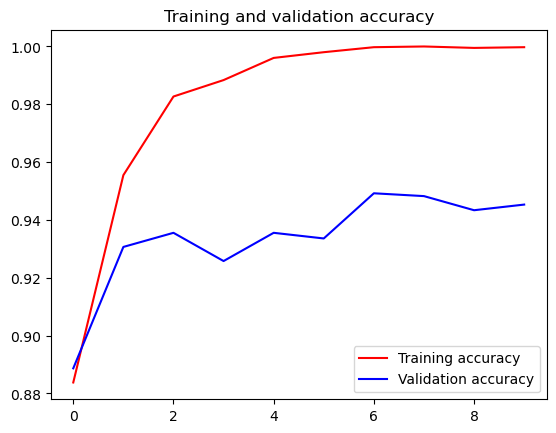

<Figure size 640x480 with 0 Axes>

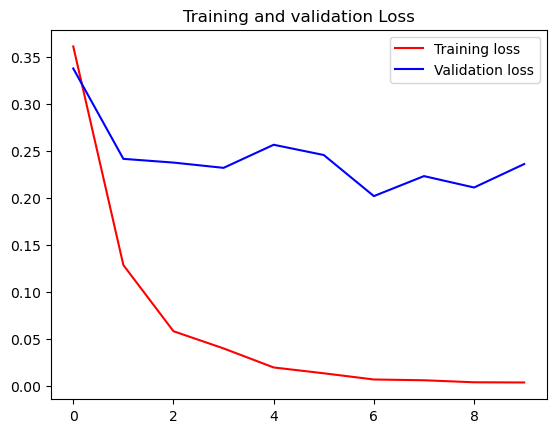

<Figure size 640x480 with 0 Axes>

33/33 [==============================] - 1s 16ms/step


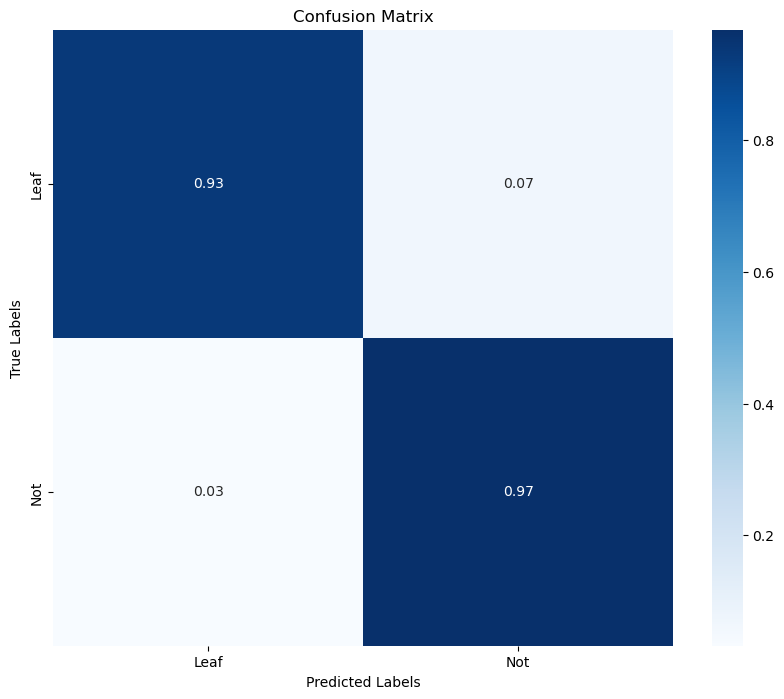

In [20]:
# Plot the training and validation accuracies for each epoch

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

#Train and Validation Accuracy
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

#Train and Validation Loss
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

# Confusion Matrix Heatmap
class_labels = sorted(os.listdir('/kaggle/input/leaf-or-not/Leaf or Not'))
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = test_generator.classes
cm = confusion_matrix(test_labels, predicted_labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='.2f', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [21]:
prediksi = model.predict(test_images)
y_pred = np.argmax(prediksi, axis=1)
# y_true = test_generator.labels

print(classification_report(test_labels, y_pred))

33/33 [==============================] - 1s 17ms/step
              precision    recall  f1-score   support

           0       0.97      0.93      0.95       525
           1       0.93      0.97      0.95       500

    accuracy                           0.95      1025
   macro avg       0.95      0.95      0.95      1025
weighted avg       0.95      0.95      0.95      1025



In [22]:
# Save model dengan fromat HDF5
tf.saved_model.save(model, "/kaggle/working/Model")
my_model = tf.saved_model.load('/kaggle/working/Model')

# convert model ke TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(my_model)
tflite_model = converter.convert()

# save TFLite model
with open('LeafAndNot.tflite', 'wb') as f:
  f.write(tflite_model)

In [23]:
import zipfile
import os

# Nama folder yang ingin Anda download
folder_name = '/kaggle/working/Model'

# Nama file ZIP yang ingin Anda berikan pada file yang diunduh
zip_file_name = 'LeafOrNot.zip'

# Mengompres folder menjadi file ZIP
with zipfile.ZipFile(zip_file_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
    for root, dirs, files in os.walk(folder_name):
        for file in files:
            file_path = os.path.join(root, file)
            zipf.write(file_path, arcname=os.path.relpath(file_path, folder_name))

# Mengunduh file ZIP
from IPython.display import FileLink
FileLink(zip_file_name)


/kaggle/working/LeafOrNot.zip

In [24]:
# Load the image
img_path = '/kaggle/input/leaf-or-not/Leaf or Not/Leaf/1023.jpg'
img = image.load_img(img_path, target_size=(300, 150))  # img_width dan img_height sesuaikan dengan ukuran yang digunakan saat training

# # Convert the image to a numpy array
# img_array = image.img_to_array(img)
# img_array = np.expand_dims(img_array, axis=0)

predict = model.predict(img)
print(predict)

ValueError: Failed to find data adapter that can handle input: <class 'PIL.Image.Image'>, <class 'NoneType'>